# Skin Lesion Seegmentation
This notebook will apply UNET Convolutional Neural Network to segment the lesion area.

***INPUT DATA***: The input data are dermoscopic lesion images in JPEG format.

**All lesion images are named using the scheme ISIC_<image_id>.jpg, where <image_id> is a 7-digit unique identifier.The lesion images were acquired with a variety of dermatoscope types, from all anatomic sites (excluding mucosa and nails), from a historical sample of patients presented for skin cancer screening, from several different institutions. Every lesion image contains exactly one primary lesion; other fiducial markers, smaller secondary lesions, or other pigmented regions may be neglected.**


***RESPONSE DATA***:
**The response data are binary mask images in PNG format, indicating the location of the primary skin lesion within each input lesion image.
Mask images are named using the scheme ISIC_<image_id>_segmentation.png, where <image_id> matches the corresponding lesion image for the mask.
Mask images must have the exact same dimensions as their corresponding lesion image. Mask images are encoded as single-channel (grayscale) 8-bit PNGs (to provide lossless compression), where each pixel is either:
0: representing the background of the image, or areas outside the primary lesion
255: representing the foreground of the image, or areas inside the primary lesion.**

In [ ]:
# prompt: mount drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 This code implements a complete pipeline for training a UNet model for image segmentation. It includes data loading and augmentation, model definition, training loop, checkpoint saving/loading, accuracy checking, and prediction saving.

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torchvision.utils
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.optim as optim
from tqdm import tqdm


# Defining key parameters for training.

In [ ]:
LEARNING_RATE = 0.0003
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
NUM_EPOCHS = 20
NUM_WORKERS = 16
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
PRE_FETCH_FACTOR = 16*2
PIN_MEMORY = True
LOAD_MODEL = False

**This model was trained locally**

In [ ]:
# Directories
base_dir = 'C:/Users/alida/Downloads/content/drive/MyDrive/Segmentation'
TRAIN_IMG_DIR = os.path.join(base_dir, 'Training_Input')
TRAIN_MASK_DIR = os.path.join(base_dir, 'Training_groundTruth/ISIC2018_Task1_Training_GroundTruth')
VAL_IMG_DIR = os.path.join(base_dir, 'Validation_Input/ISIC2018_Task1-2_Validation_Input')
VAL_MASK_DIR = os.path.join(base_dir, 'ValidationGroundTruths/ISIC2018_Task1_Validation_GroundTruth')
TEST_IMG_DIR = os.path.join(base_dir, 'Test_Input/ISIC2018_Task1-2_Test_Input')
TEST_MASK_DIR = os.path.join(base_dir, 'test_ground_truth/ISIC2018_Task1_Test_GroundTruth')
MODEL_SAVE_PATH = 'C:/Users/alida/Downloads/content/drive/MyDrive/Saved_Models/my_checkpoint.pth.tar'

# Defines a basic building block with two convolutional layers followed by batch normalization and ReLU activation. This is used in both the encoder and decoder parts of the UNet.

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

**UNET Class**: Defines the full UNet architecture. The __init__ method sets up the layers for both the encoder (down path) and decoder (up path), including the bottleneck.

The **forward** method defines the forward pass through the network, including skip connections that are concatenated in the decoder part.





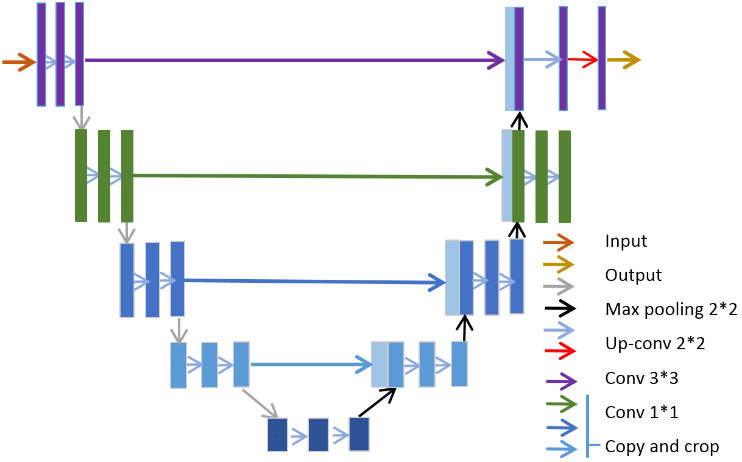


In [ ]:
class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNet
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNet
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(feature * 2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)
        return self.final_conv(x)

**Custom dataset class for the ISIC 2018 dataset. It handles loading, grayscale conversion, histogram equalization, and any additional transformations.**

In [ ]:
class ISIC2018Dataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace('.jpg', '_segmentation.png'))
        sample = {}
        sample['image'] = img_path
        sample['mask'] = mask_path
        # image = np.array(Image.open(img_path).convert("L"))
        # image = cv2.equalizeHist(image)
        # mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        # mask[mask == 255] = 1.0

        if self.transform is not None:
            # augmentations = self.transform(image=image, mask=mask)
            # image = augmentations["image"]
            # mask = augmentations["mask"]
            self.transform(sample)

        return sample


In [ ]:
class LoadImage():
  def __init__(self,keys):
    self.keys = keys
  def __call__(self,sample):
    for key in self.keys:
      sample[key] = np.array(Image.open(sample[key]).convert("L"))
    return sample

class Resize():
  def __init__(self,keys,image_height,image_width):
    self.keys = keys
    self.image_height = image_height
    self.image_width = image_width

  def __call__(self,sample):
    for key in self.keys:
      sample[key] = A.Resize(height=self.image_height,width=self.image_width)(sample[key])
    return sample

In [ ]:
tt = A.Compose([
    LoadImage(keys=['image','mask']),
    Resize(keys=['image'],)
])

<h1>Data Augmentation:</h1>
Using the Albumentations library for data augmentation. The training transformations include resizing, rotation, flipping, normalization, and converting to PyTorch tensors. Validation transformations include resizing, normalization, and tensor conversion. Data augmentation helps improve the generalization capability of the model by introducing variations in the training data.

In [ ]:
train_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Rotate(limit=35, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Normalize(mean=[0.0], std=[1.0], max_pixel_value=255.0),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Normalize(mean=[0.0], std=[1.0], max_pixel_value=255.0),
    ToTensorV2(),
])
test_transform = val_transform


These functions handle saving and loading model checkpoints to/from Drive, which is useful for saving the model state after training and resuming training if needed.

In [ ]:
def save_checkpoint(state, filename=MODEL_SAVE_PATH):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def get_loaders(train_dir, train_maskdir, val_dir, val_maskdir, test_dir, test_maskdir, batch_size, train_transform, val_transform, test_transform, num_workers=4, pin_memory=True):
    train_ds = ISIC2018Dataset(image_dir=train_dir, mask_dir=train_maskdir, transform=train_transform)
    val_ds = ISIC2018Dataset(image_dir=val_dir, mask_dir=val_maskdir, transform=val_transform)
    test_ds = ISIC2018Dataset(image_dir=test_dir, mask_dir=test_maskdir, transform=test_transform)

    train_loader = DataLoader(train_ds, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

    return train_loader, val_loader, test_loader


Accuracy Calculation: Counts the number of correctly predicted pixels (num_correct) and the total number of pixels (num_pixels). It then calculates accuracy as num_correct/num_pixels.

Dice Score Calculation: For each batch, calculates the Dice score by measuring the overlap between the predicted and ground truth masks.

In [ ]:
def check_accuracy(loader, model, device):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)

    print(f"Got {num_correct}/{num_pixels} with acc {num_correct / num_pixels * 100:.2f}")
    print(f"Dice score: {dice_score / len(loader)}")
    model.train()



def save_predictions_as_imgs(loader, model, folder="C:/Users/alida/Downloads/content/drive/MyDrive/Saved_Images", device="cuda"):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            torchvision.utils.save_image(preds, f"{folder}/pred_{idx}.png")
            torchvision.utils.save_image(y.unsqueeze(1), f"{folder}/mask_{idx}.png")
    model.train()


Defines the training loop for one epoch, including forward pass, loss computation, backward pass, and optimization. It uses mixed precision training to speed up the process and reduce memory usage.

In [ ]:
def train_fn(loader, model, optimizer, loss_fn, scaler, device):
    loop = tqdm(loader, leave=True)
    losses = []

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=device)
        targets = targets.to(device=device).unsqueeze(1)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loop.set_postfix(loss=loss.item())
        losses.append(loss.item())

    return losses


In [ ]:
## added to fit the new dataset loader
def train_fn(loader, model, optimizer, loss_fn, scaler, device):
    loop = tqdm(loader, leave=True)
    losses = []

    for batch_idx, data in enumerate(loop):
        inputs = data['image'].to(device=device)
        targets = data['mask'].to(device=device).unsqueeze(1)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            predictions = model(inputs)
            loss = loss_fn(predictions, targets)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loop.set_postfix(loss=loss.item())
        losses.append(loss.item())

    return losses


This is the entry point for running the training. It sets up the model, data loaders, and training loop. It also handles loading a pre-trained model if specified, saving model checkpoints after each epoch, checking accuracy, and saving predictions.

C:\Users\alida\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\cuda\amp\grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
  0%|                                                                                            | 0/8 [00:00<?, ?it/s]C:\Users\alida\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████| 8/8 [05:03<00:00, 37.98s/it, loss=0.427]


Got 3538157/5017600 with acc 70.51
Dice score: 0.5731940269470215


100%|████████████████████████████████████████████████████████████████████████| 4/4 [01:53<00:00, 28.47s/it, loss=0.329]


=> Saving checkpoint


100%|████████████████████████████████████████████████████████████████████████| 8/8 [05:23<00:00, 40.48s/it, loss=0.834]


Got 2690192/5017600 with acc 53.62
Dice score: 0.5018269419670105


100%|████████████████████████████████████████████████████████████████████████| 4/4 [01:57<00:00, 29.27s/it, loss=0.283]


=> Saving checkpoint


100%|████████████████████████████████████████████████████████████████████████| 8/8 [05:02<00:00, 37.80s/it, loss=0.253]


Got 1520955/5017600 with acc 30.31
Dice score: 0.41238510608673096


100%|████████████████████████████████████████████████████████████████████████| 4/4 [01:52<00:00, 28.25s/it, loss=0.239]


=> Saving checkpoint


100%|████████████████████████████████████████████████████████████████████████| 8/8 [04:46<00:00, 35.84s/it, loss=0.519]


Got 4384856/5017600 with acc 87.39
Dice score: 0.7684650421142578


100%|████████████████████████████████████████████████████████████████████████| 4/4 [01:55<00:00, 28.79s/it, loss=0.233]


=> Saving checkpoint


100%|████████████████████████████████████████████████████████████████████████| 8/8 [04:47<00:00, 35.99s/it, loss=0.298]


Got 4176530/5017600 with acc 83.24
Dice score: 0.7061031460762024


100%|████████████████████████████████████████████████████████████████████████| 4/4 [01:50<00:00, 27.62s/it, loss=0.244]


=> Saving checkpoint


100%|████████████████████████████████████████████████████████████████████████| 8/8 [04:48<00:00, 36.00s/it, loss=0.242]


Got 4396457/5017600 with acc 87.62
Dice score: 0.7526651620864868


100%|████████████████████████████████████████████████████████████████████████| 4/4 [01:50<00:00, 27.73s/it, loss=0.217]


=> Saving checkpoint


100%|████████████████████████████████████████████████████████████████████████| 8/8 [04:46<00:00, 35.76s/it, loss=0.428]


Got 3808975/5017600 with acc 75.91
Dice score: 0.5545653700828552


100%|████████████████████████████████████████████████████████████████████████| 4/4 [01:48<00:00, 27.05s/it, loss=0.212]


=> Saving checkpoint


100%|████████████████████████████████████████████████████████████████████████| 8/8 [04:44<00:00, 35.59s/it, loss=0.221]


Got 4347345/5017600 with acc 86.64
Dice score: 0.7456194162368774


100%|████████████████████████████████████████████████████████████████████████| 4/4 [01:49<00:00, 27.27s/it, loss=0.203]


=> Saving checkpoint


100%|████████████████████████████████████████████████████████████████████████| 8/8 [04:51<00:00, 36.42s/it, loss=0.183]


Got 4355743/5017600 with acc 86.81
Dice score: 0.7280713319778442


100%|████████████████████████████████████████████████████████████████████████| 4/4 [01:49<00:00, 27.38s/it, loss=0.199]


=> Saving checkpoint


100%|████████████████████████████████████████████████████████████████████████| 8/8 [04:45<00:00, 35.66s/it, loss=0.183]


Got 4465642/5017600 with acc 89.00
Dice score: 0.7830774188041687


100%|████████████████████████████████████████████████████████████████████████| 4/4 [01:49<00:00, 27.26s/it, loss=0.207]


=> Saving checkpoint


100%|████████████████████████████████████████████████████████████████████████| 8/8 [04:44<00:00, 35.52s/it, loss=0.608]


Got 4186132/5017600 with acc 83.43
Dice score: 0.599021852016449


100%|████████████████████████████████████████████████████████████████████████| 4/4 [01:49<00:00, 27.31s/it, loss=0.256]


=> Saving checkpoint


100%|████████████████████████████████████████████████████████████████████████| 8/8 [04:48<00:00, 36.02s/it, loss=0.183]


Got 4249603/5017600 with acc 84.69
Dice score: 0.7439447641372681


100%|████████████████████████████████████████████████████████████████████████| 4/4 [01:48<00:00, 27.23s/it, loss=0.171]


=> Saving checkpoint


100%|████████████████████████████████████████████████████████████████████████| 8/8 [04:46<00:00, 35.82s/it, loss=0.643]


Got 4395376/5017600 with acc 87.60
Dice score: 0.739510178565979


100%|████████████████████████████████████████████████████████████████████████| 4/4 [01:48<00:00, 27.14s/it, loss=0.203]


=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 8/8 [04:44<00:00, 35.56s/it, loss=1.13]


Got 4448227/5017600 with acc 88.65
Dice score: 0.775132954120636


100%|████████████████████████████████████████████████████████████████████████| 4/4 [01:48<00:00, 27.23s/it, loss=0.213]


=> Saving checkpoint


100%|████████████████████████████████████████████████████████████████████████| 8/8 [04:46<00:00, 35.82s/it, loss=0.241]


Got 4489139/5017600 with acc 89.47
Dice score: 0.8001128435134888


100%|████████████████████████████████████████████████████████████████████████| 4/4 [01:48<00:00, 27.20s/it, loss=0.172]


=> Saving checkpoint


100%|████████████████████████████████████████████████████████████████████████| 8/8 [04:48<00:00, 36.06s/it, loss=0.374]


Got 4427811/5017600 with acc 88.25
Dice score: 0.7633665800094604


100%|████████████████████████████████████████████████████████████████████████| 4/4 [01:49<00:00, 27.40s/it, loss=0.176]


=> Saving checkpoint


100%|████████████████████████████████████████████████████████████████████████| 8/8 [04:46<00:00, 35.77s/it, loss=0.594]


Got 4404780/5017600 with acc 87.79
Dice score: 0.7464316487312317


100%|████████████████████████████████████████████████████████████████████████| 4/4 [01:49<00:00, 27.42s/it, loss=0.225]


=> Saving checkpoint


100%|█████████████████████████████████████████████████████████████████████████| 8/8 [04:46<00:00, 35.76s/it, loss=0.18]


Got 3995543/5017600 with acc 79.63
Dice score: 0.6819042563438416


100%|████████████████████████████████████████████████████████████████████████| 4/4 [01:49<00:00, 27.34s/it, loss=0.159]


=> Saving checkpoint


100%|████████████████████████████████████████████████████████████████████████| 8/8 [04:47<00:00, 35.93s/it, loss=0.572]


Got 4388717/5017600 with acc 87.47
Dice score: 0.7404134273529053


100%|████████████████████████████████████████████████████████████████████████| 4/4 [01:49<00:00, 27.44s/it, loss=0.171]


=> Saving checkpoint


100%|████████████████████████████████████████████████████████████████████████| 8/8 [04:44<00:00, 35.58s/it, loss=0.223]


Got 4492269/5017600 with acc 89.53
Dice score: 0.804486870765686


100%|████████████████████████████████████████████████████████████████████████| 4/4 [01:47<00:00, 26.84s/it, loss=0.154]


=> Saving checkpoint


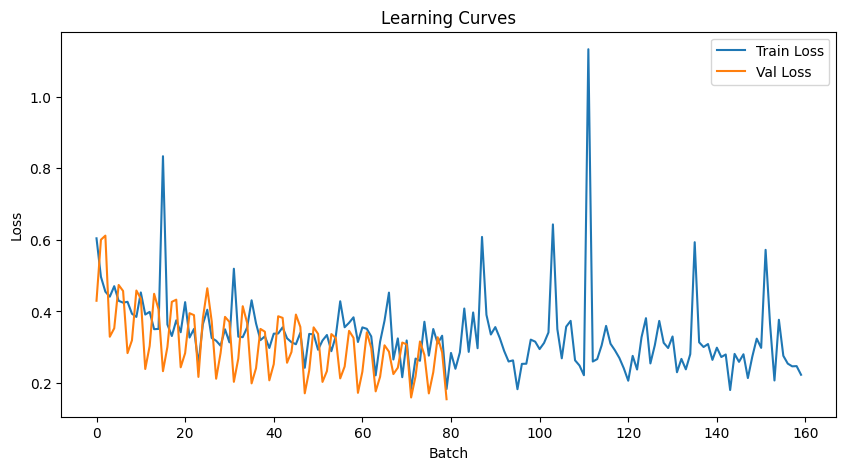

In [ ]:
def main():
    model = UNET(in_channels=1, out_channels=1).to(DEVICE)
    loss_fn = nn.BCEWithLogitsLoss() ## Dice Loss
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) ## AdamW

    train_loader, val_loader, test_loader = get_loaders(
        TRAIN_IMG_DIR,
        TRAIN_MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        TEST_IMG_DIR,
        TEST_MASK_DIR,
        BATCH_SIZE,
        train_transform,
        val_transform,
        test_transform,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY
    )
    scaler = torch.cuda.amp.GradScaler()
    train_losses = []
    val_losses = []

    if LOAD_MODEL:
        load_checkpoint(torch.load("MODEL_SAVE_PATH"), model)

    for epoch in range(NUM_EPOCHS):
        train_loss = train_fn(train_loader, model, optimizer, loss_fn, scaler, DEVICE)
        train_losses.extend(train_loss)
        check_accuracy(val_loader, model, DEVICE)
        val_loss = train_fn(val_loader, model, optimizer, loss_fn, scaler, DEVICE)
        val_losses.extend(val_loss)

        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
        save_checkpoint(checkpoint)

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Learning Curves')
    plt.legend()
    plt.show()
    model.eval()
    with torch.no_grad():
        for idx, (x, y) in enumerate(test_loader):
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            torchvision.utils.save_image(preds, f"C:/Users/alida/Downloads/content/drive/MyDrive/Saved_Images/test_pred_{idx}.png")
            torchvision.utils.save_image(y.unsqueeze(1), f"C:/Users/alida/Downloads/content/drive/MyDrive/Saved_Images/test_true_{idx}.png")

if __name__ == "__main__":
    main()

**The plot shows the learning curves for the training and validation loss over the batches during training. **

1.   Training loss

*   In the beginning the training loss is relatively high indicting that the model is not well fitted to the training data at the beginning however over time the training data the loss generally decreases.
*   Spikes in training could be due to the noisy data


2.   Validation loss

*   Validation loss decreases overtime but shows some fluctuations. This is an indication how well the model generalizes to unseen data
*  The validation loss seems to generally decrease, suggesting that the model is not overfitting significantly.







**Visualizing the actual vs the predicted**

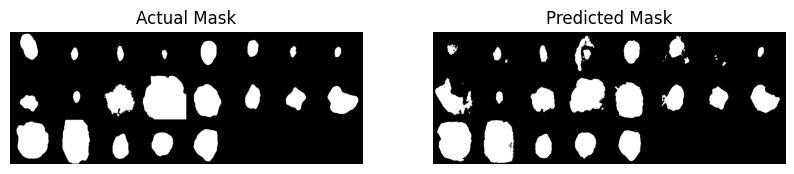

In [ ]:
base_img = "C:/Users/alida/Downloads/content/drive/MyDrive/Saved_Images"
Test_Actual =  os.path.join(base_img, 'test_true_0.png')
Tets_Pred =  os.path.join(base_img, 'test_pred_0.png')

img_Act = cv2.imread(Test_Actual)
img_pred = cv2.imread(Tets_Pred)


f, axarr = plt.subplots(1, 2, figsize=(10, 5))

axarr[0].imshow(img_Act)
axarr[0].set_title('Actual Mask')
axarr[0].axis('off')

axarr[1].imshow(img_pred)
axarr[1].set_title('Predicted Mask')
axarr[1].axis('off')

plt.show()

In [ ]:
# Exp1: Unet lr 0.0001 batch 32 DiceLoss
# Exp2: ResNET lr 0.0001 batch 32 DiceLoss